### Project relevance and main business question
This document aims at investigating the world wide box office of movies in the sales dataset, attempting to answer the following business question: 
"How can movie producers increase their revenue by predicting the box office of upcoming movies and understanding audience preferences? "

Investingating sales data about previous movies can reveal insightful ways to predict potential box office for upcoming films accurately.  Movie producers can use this information to inform investment-related decisions. 
This main research question will be answered through supervice and unsupervised learning techniques. The section below presents the subquestions answered by each part.  


### Research questions for supervised learning (random forest and neural network)
1) Which model is the most adequate for this business case?
2) What are the most important predictors of movies' box office?
3) What is the relationship between these predictors and the predicted box office?

### Research questions for unsupervised learning (clustering)
1) What is the most adequate clustering method for this business case? 
2) Which features can provide insights into audience preferences?
3) What else movie producers imply from the clustering analysis? 

### Exploratory data analysis, data cleaning of the dataset sales, and Feature engineer.

In [25]:
#importing the basic libraries
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt 
import numpy as np
from IPython.core.display import HTML

#from plotnine import *
import warnings
warnings.filterwarnings('ignore')


In [26]:
#reading the excel file of sales dataset
df = pd.read_excel('sales.xlsx')


In [27]:
#deleting columns that are not relevant for further analysis (on the base of research questions)
columns_to_drop = ['Unnamed: 8', 'international_box_office', 'domestic_box_office', 'release_date', 'opening_weekend', 'avg run per theatre', 'keywords', 'creative_type', 'url'] #column names to drop
df = df.drop(columns=columns_to_drop)  #remove specified columns
df.rename(columns={'runtime': 'duration'}, inplace=True)  #rename the columns 'runtime' to 'duration' for logical reasons 
df.head() #show the first 5 rows of the dataset 

,year,title,genre,worldwide_box_office,production_budget,theatre_count,duration
0,2000,Bakha Satang,Drama,76576.0,NaN,NaN,129.0
1,2001,Antitrust,Thriller/Suspense,17865209.0,30000000.0,2433.0,NaN
2,2000,Santitos,NaN,NaN,NaN,NaN,105.0
3,2002,Frank McKlusky C.I.,NaN,NaN,NaN,NaN,NaN
4,2002,A Walk to Remember,Drama,46060861.0,11000000.0,2411.0,NaN


Relying on the research questions the columns above mentioned have been removed from the dataset. 

In [28]:
#datatype check
df.dtypes

year                      int64
title                    object
genre                    object
worldwide_box_office    float64
production_budget       float64
theatre_count           float64
duration                float64
dtype: object

In [29]:
# Checking for duplicates in the whole dataset
duplicate_rows = df.duplicated().sum()
print('Duplicates in this dataset:', duplicate_rows)

df_rows = len(df)
print(f"Rows in dataset: {df_rows}")

# Remove duplicate rows
df_no_duplicates = df[~df.duplicated()]


Duplicates in this dataset: 0
Rows in dataset: 30612


Any duplicate has been successfully removed from the dataset.

In [30]:
#checking how many NaN values for each distinct variable
NaN_count = df.isnull().sum()
NaN_summary = pd.DataFrame({
    'Missing Values Count': NaN_count
})
print(NaN_summary)

                      Missing Values Count
year                                     0
title                                    8
genre                                 1704
worldwide_box_office                  9037
production_budget                    26132
theatre_count                        19649
duration                              6053


The dataset contains several NaN values. These ones will be handled differently for categorical and numerical variables in the dataset. For categorical variables, they will be filled with "unknown" , while for numerical ones they will be filled in with either their mean or median (depending on their distribution).

In [31]:
#replacing missing values (categorical variables)
# Replace NaN values in columns of type 'object' (string) with 'Unknown'
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns] = df[object_columns].fillna("Unknown")

# Checking if there are any remaining missing values
missing_values_after_imputation_categorical= df[object_columns].isnull().sum()
print("Missing values in categorical variables after imputation:")
print(missing_values_after_imputation_categorical)

df.head() 

Missing values in categorical variables after imputation:
title    0
genre    0
dtype: int64


,year,title,genre,worldwide_box_office,production_budget,theatre_count,duration
0,2000,Bakha Satang,Drama,76576.0,NaN,NaN,129.0
1,2001,Antitrust,Thriller/Suspense,17865209.0,30000000.0,2433.0,NaN
2,2000,Santitos,Unknown,NaN,NaN,NaN,105.0
3,2002,Frank McKlusky C.I.,Unknown,NaN,NaN,NaN,NaN
4,2002,A Walk to Remember,Drama,46060861.0,11000000.0,2411.0,NaN


The are no more NaN values in the categorical variables, they have been replaced by "unknown". To handle NaN in numerical variables, the distribution of each of them will be plotted to decide whether to use mean or median to impute them.

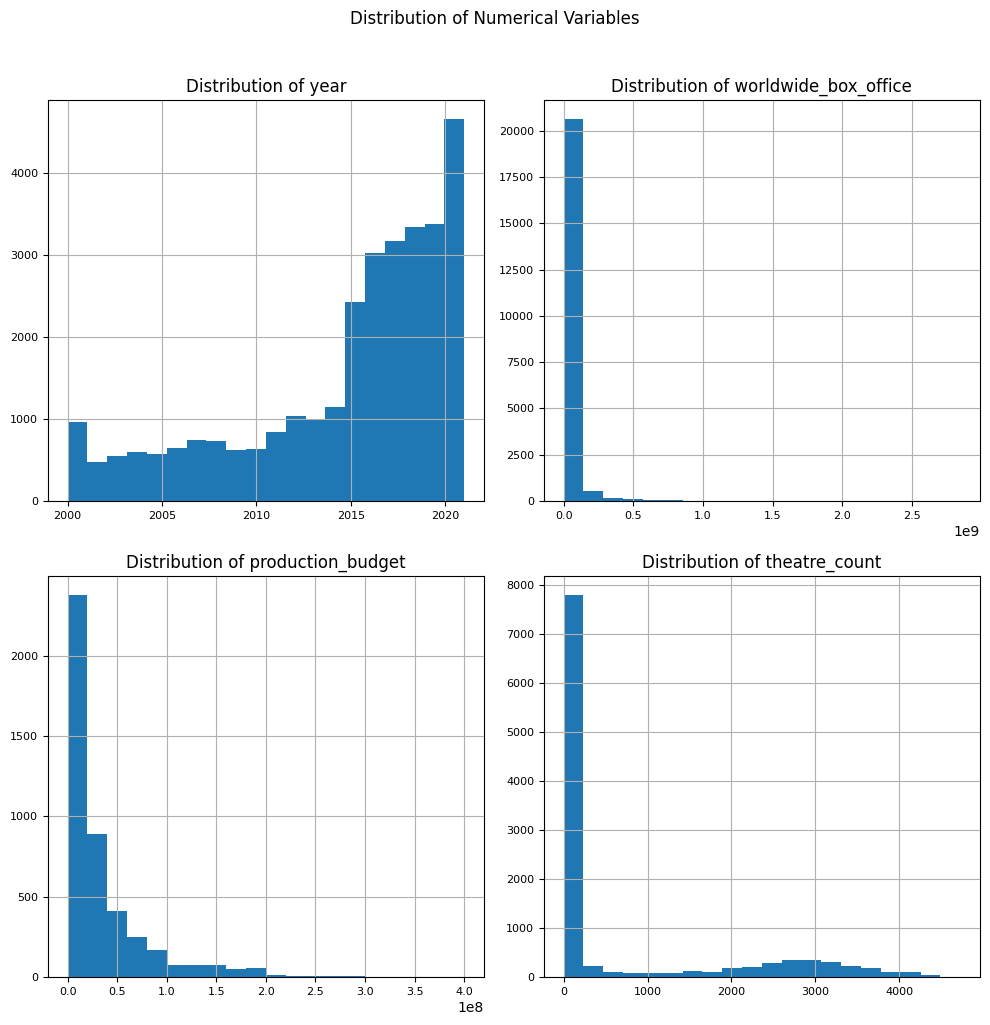

In [32]:
#replacing missing values (numerical variables)
#plotting distribution of numerical variables to decide whether to use mean or median to fill missing values

# histograms of numerical variables
#  drop non-numeric columns 
numerical_columns = df.select_dtypes(include='number').columns

# Plot histograms for all numerical variables with titles
fig, axes = plt.subplots(nrows=len(numerical_columns) // 2, ncols=2, figsize=(10, 10))
fig.suptitle('Distribution of Numerical Variables', y=1.02)

for ax, col in zip(axes.flatten(), numerical_columns):
    df[col].hist(ax=ax, bins=20)
    ax.set_title(f'Distribution of {col}')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()


Since all of the numerical variables have a skewed distribution, their median can be used to impute the NaN values.

In [33]:
# Get the list of numerical columns
numerical_columns = df.select_dtypes(include='number').columns

# Impute missing values with the median for all numerical columns
for column in numerical_columns:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Checking if there are any remaining missing values
missing_values_after_imputation = df[numerical_columns].isnull().sum()
print("Missing values in numerical variables after imputation:")
print(missing_values_after_imputation)

df.head(20)

Missing values in numerical variables after imputation:
year                    0
worldwide_box_office    0
production_budget       0
theatre_count           0
duration                0
dtype: int64


,year,title,genre,worldwide_box_office,production_budget,theatre_count,duration
0,2000,Bakha Satang,Drama,76576.0,20000000.0,8.0,129.0
1,2001,Antitrust,Thriller/Suspense,17865209.0,30000000.0,2433.0,97.0
2,2000,Santitos,Unknown,475322.0,20000000.0,8.0,105.0
3,2002,Frank McKlusky C.I.,Unknown,475322.0,20000000.0,8.0,97.0
4,2002,A Walk to Remember,Drama,46060861.0,11000000.0,2411.0,97.0
5,2002,Zig Zag,Unknown,475322.0,20000000.0,1.0,97.0
6,2002,TakhtÃƒÂ© siah,Drama,475322.0,20000000.0,5.0,97.0
7,2009,"Angry Monk: Reflections on Tibet, The",Documentary,475322.0,20000000.0,1.0,97.0
8,2002,30 Years to Life,Comedy,475322.0,20000000.0,1.0,97.0
9,2008,The Killing of John Lennon,Drama,475322.0,20000000.0,1.0,97.0


The NaN values for the numerical variables have been replaced by their median. This means that all NaN values in the dataset have been filled in. 

Next, the variable title lenght and market potential ( a score indicating the market potential of a movie) will be created on the basis of features already present in the sales dataset.  

In [34]:
#creating variable titlte lenght 
# Convert the 'title' column to strings and create the 'title_length' column
df['title_length'] = df['title'].astype(str).apply(len)
# Print the first 5 values of the 'title_length' column
print(df['title_length'].head().values)
print(df['title_length'].dtype)  #checking variable is an int 

[12  9  8 19 18]
int64



The variable title lenght was created from the movies' title to investigate whether the lenght of a movie title could be somehow linked to its box office. The shortest title has only 1 character while the longest one is 271 character long. The movie with the longest title is "ÃÅ¸Ãï¿½ÃÂ Ãâ€¢Ãï¿½ÃÂ¬ ÃËœÃâ€” Ãâ€œÃÅ¾Ãâ€ºÃâ€ºÃËœÃâ€™ÃÂ£Ãâ€Ãï¿½" (name shortened), while the movie with the shortest title was "2".

The next variable that will be created is market potential, obtained by multiplying the production budget by the number of threatres in which a movie is displayed. This was done assuming that both a movie's budget and its threatre count represent indicators of their market potential. However, to test whether this assumption is true (and thus that the variable market potential can be used ) a correlation analysis was performed to test the relationship between prodcution budget, threatre count, and world wide box office.


Correlation between production budget and worldwide box office: 0.7709583751311655
p-value: 0.0
Correlation between theatre count and worldwide box office: 0.6239371770617874
p-value: 0.0


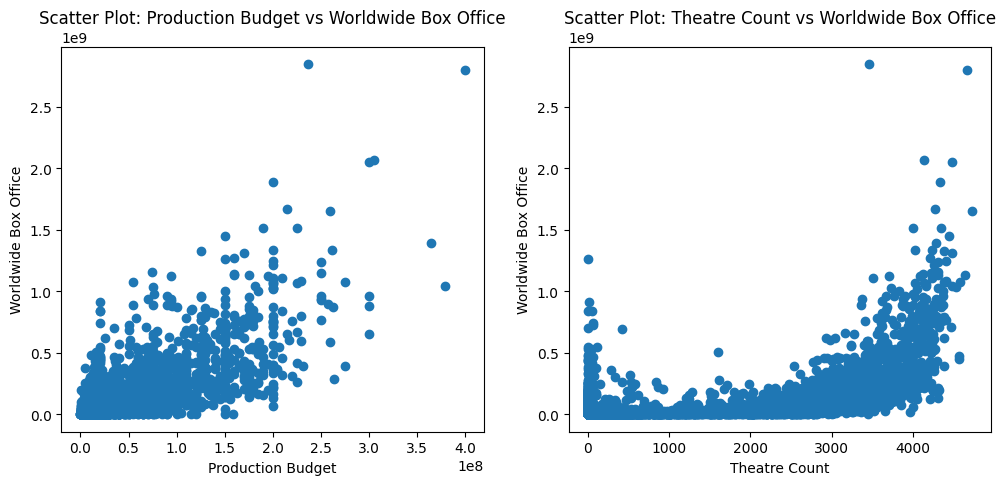

In [35]:
from scipy.stats import pearsonr

# Calculate the correlation between production budget and worldwide box office
production_budget_corr, production_budget_pval = pearsonr(df['production_budget'], df['worldwide_box_office'])
print("Correlation between production budget and worldwide box office:", production_budget_corr)
print("p-value:", production_budget_pval)

# Calculate the correlation between theatre count and worldwide box office
theatre_count_corr, theatre_count_pval = pearsonr(df['theatre_count'], df['worldwide_box_office'])
print("Correlation between theatre count and worldwide box office:", theatre_count_corr)
print("p-value:", theatre_count_pval)

#plotting variables 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df['production_budget'], df['worldwide_box_office'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Box Office')
plt.title('Scatter Plot: Production Budget vs Worldwide Box Office')

plt.subplot(1, 2, 2)
plt.scatter(df['theatre_count'], df['worldwide_box_office'])
plt.xlabel('Theatre Count')
plt.ylabel('Worldwide Box Office')
plt.title('Scatter Plot: Theatre Count vs Worldwide Box Office')
plt.show()

Both production budget (r = 0.77, p < .001) and theatre count (r = 0.62, p < .001) are positively correlated with worldwide box office. Both correlations are fairly strong (especially the one between production budget and worldwide box office) For this reason, these variables were combined to create the variable market potential. 

In [37]:
#creating variable market potential (obtained by multiplying production budget by theatre_count)
df['market_potential'] = df['production_budget'] * df['theatre_count']
# Print the first 5 values of the 'market_potential' column
print(df['market_potential'].head().values)
print(df['title_length'].dtype)  #checking variable is an int 

[1.6000e+08 7.2990e+10 1.6000e+08 1.6000e+08 2.6521e+10]
int64


The variable market potential was created by multiplying the production budget by the number of threatres in which a movie was displayed. The movie with the highest market potential score is Endgame while the movie with the lowest one is Return to the Land of Wonders.

The cell below displays a summary (count, mean, std (standard deviation), min, 25%, 50% , 75%(median), and max) of the numerical variables in the dataset.

In [43]:
# Append 'title_length' and 'market_potential' to the numerical columns list
numerical_columns.extend(['title_length', 'market_potential'])

# Summary numerical variables 
summary_variables = df[numerical_columns].describe()
print(summary_variables)

# Print the updated list of numerical columns
print(numerical_columns)

               year  worldwide_box_office  production_budget  theatre_count  \
count  30612.000000          3.061200e+04       3.061200e+04   30612.000000   
mean    2014.542108          1.793481e+07       2.240338e+07     264.113844   
std        5.525085          8.552334e+07       1.868864e+07     820.910010   
min     2000.000000          2.000000e+00       1.100000e+03       1.000000   
25%     2012.000000          1.059175e+05       2.000000e+07       8.000000   
50%     2016.000000          4.753220e+05       2.000000e+07       8.000000   
75%     2019.000000          1.957475e+06       2.000000e+07       8.000000   
max     2021.000000          2.845900e+09       4.000000e+08    4725.000000   

           duration  title_length  market_potential  title_length  \
count  30612.000000  30612.000000      3.061200e+04  30612.000000   
mean     100.612603     17.151542      1.562980e+10     17.151542   
std       24.423635     10.553246      7.934872e+10     10.553246   
min       11

In [44]:
#PRODUCTION BUDGET
# Find the index of the movie with the highest production budget
max_budget_index = df['production_budget'].idxmax()
# Find the index of the movie with the lowest production budget
min_budget_index = df['production_budget'].idxmin()
# Get the titles and production budgets of the movies
title_highest_budget = df.loc[max_budget_index, 'title']
title_lowest_budget = df.loc[min_budget_index, 'title']
production_budget_highest = df.loc[max_budget_index, 'production_budget']
production_budget_lowest = df.loc[min_budget_index, 'production_budget']

print("Movie with the highest production budget:", title_highest_budget)
print("Production budget of the movie with the highest production budget:", production_budget_highest)
print("Movie with the lowest production budget:", title_lowest_budget)
print("Production budget of the movie with the lowest production budget:", production_budget_lowest)


#YEAR (of release)
# Find the index of the movie with the oldest release year
oldest_movie_index = df['year'].idxmin()
# Find the index of the movie with the newest release year
newest_movie_index = df['year'].idxmax()
# Get the titles and release years of the oldest and newest movies
title_oldest_movie = df.loc[oldest_movie_index, 'title']
title_newest_movie = df.loc[newest_movie_index, 'title']
year_oldest_movie = df.loc[oldest_movie_index, 'year']
year_newest_movie = df.loc[newest_movie_index, 'year']

print("Title of the oldest movie:", title_oldest_movie)
print("Year of release of the oldest movie:", year_oldest_movie)
print("Title of the newest movie:", title_newest_movie)
print("Year of release of the newest movie:", year_newest_movie)


# DURATION
# Find the index of the movie with the longest duration
longest_movie_index = df['duration'].idxmax()
# Find the index of the movie with the shortest duration
shortest_movie_index = df['duration'].idxmin()
# Get the titles and durations of the longest and shortest movies
title_longest_movie = df.loc[longest_movie_index, 'title']
title_shortest_movie = df.loc[shortest_movie_index, 'title']
duration_longest_movie = df.loc[longest_movie_index, 'duration']
duration_shortest_movie = df.loc[shortest_movie_index, 'duration']

print("Title of the longest movie:", title_longest_movie)
print("Duration of the longest movie:", duration_longest_movie, "minutes")
print("Title of the shortest movie:", title_shortest_movie)
print("Duration of the shortest movie:", duration_shortest_movie, "minutes")



#THEATRE COUNT
# Find the index of the movie with the highest theatre count
max_theatre_index = df['theatre_count'].idxmax()
# Find the index of the movie with the lowest theatre count
min_theatre_index = df['theatre_count'].idxmin()
# Get the titles and theatre counts of the movies
title_highest_theatre = df.loc[max_theatre_index, 'title']
title_lowest_theatre = df.loc[min_theatre_index, 'title']
theatre_count_highest = df.loc[max_theatre_index, 'theatre_count']
theatre_count_lowest = df.loc[min_theatre_index, 'theatre_count']

print("Title of the movie with the highest theatre count:", title_highest_theatre)
print("Theatre count of the movie with the highest theatre count:", theatre_count_highest)
print("Title of the movie with the lowest theatre count:", title_lowest_theatre)
print("Theatre count of the movie with the lowest theatre count:", theatre_count_lowest)



#TITLE LENGHT
# Find the index of the movie with the longest title
max_title_length_index = df['title_length'].idxmax()
# Find the index of the movie with the shortest title
min_title_length_index = df['title_length'].idxmin()
# Get the titles of the movies
title_longest_title = df.loc[max_title_length_index, 'title']
title_shortest_title = df.loc[min_title_length_index, 'title']

# Print the length of the longest and shortest titles along with their titles
print("Longest Title length:", df['title_length'].max())
print("Title of the movie with the longest title:", title_longest_title)
print("Shortest Title length:", df['title_length'].min())
print("Title of the movie with the shortest title:", title_shortest_title)


#MARKET POTENTIAL
# Find the index of the movie with the maximum market potential
max_market_potential_index = df['market_potential'].idxmax()
# Find the index of the movie with the minimum market potential
min_market_potential_index = df['market_potential'].idxmin()
# Get the titles of the movies
title_max_market_potential = df.loc[max_market_potential_index, 'title']
title_min_market_potential = df.loc[min_market_potential_index, 'title']

print("Movie with the maximum market potential:", title_max_market_potential)
print("Movie with the minimum market potential:", title_min_market_potential)

#WORLD WIDE BOX OFFICE
# Find the index of the movie with the highest worldwide box office
max_box_office_index = df['worldwide_box_office'].idxmax()
# Find the index of the movie with the lowest worldwide box office
min_box_office_index = df['worldwide_box_office'].idxmin()
# Get the titles and worldwide box office of the movies
title_highest_box_office = df.loc[max_box_office_index, 'title']
title_lowest_box_office = df.loc[min_box_office_index, 'title']
box_office_highest = df.loc[max_box_office_index, 'worldwide_box_office']
box_office_lowest = df.loc[min_box_office_index, 'worldwide_box_office']

print("Title of the movie with the highest worldwide box office:", title_highest_box_office)
print("Worldwide box office of the movie with the highest worldwide box office:", box_office_highest)
print("Title of the movie with the lowest worldwide box office:", title_lowest_box_office)
print("Worldwide box office of the movie with the lowest worldwide box office:", box_office_lowest)




Movie with the highest production budget: Avengers: Endgame
Production budget of the movie with the highest production budget: 400000000.0
Movie with the lowest production budget: My Date With Drew
Production budget of the movie with the lowest production budget: 1100.0
Title of the oldest movie: Bakha Satang
Year of release of the oldest movie: 2000
Title of the newest movie: Doraemon Nobita no TaiyÃ…ï¿½Ã…ï¿½ Densetsu
Year of release of the newest movie: 2021
Title of the longest movie: Barbara Lee: Speaking Truth to Power
Duration of the longest movie: 2020.0 minutes
Title of the shortest movie: Read My Lips
Duration of the shortest movie: 11.0 minutes
Title of the movie with the highest theatre count: The Lion King
Theatre count of the movie with the highest theatre count: 4725.0
Title of the movie with the lowest theatre count: Zig Zag
Theatre count of the movie with the lowest theatre count: 1.0
Longest Title length: 271
Title of the movie with the longest title: ÃÅ¸Ãï¿½ÃÂ Ãâ€

In the sales dataset :
The movie with the highest production budget is Avengers: Endgame (400000000), while the movie with the lowest one is My Date With Drew (1100)
The newest movies is  Doraemon Nobita no TaiyÃ…ï¿½Ã…ï¿½ Densetsu (2021) while the oldest one is Bakha Satang (2000)
The longest movie is Barbara Lee: Speaking Truth to Power (around 33 hours) while the shortest one is Read My Lips (11 min)
The movie displayed in most threaters is The Lion King ( 4725 theatre) while the one with the lowest theatre count is ZigZag (1 threatre)
The movie with the longest title (271 characters) starts with "ÃÅ¸Ãï¿½ÃÂ Ãâ€¢Ãï¿½ÃÂ¬" and the movie with the shortest title is "2".
The movie with the highest market potential index is Endgame, meaning that it has the highest combination of production budget and threatre count. The movie with the lowest score for market potential is Return to the Land of Wonders.
The movie with the highest worldwide box office  is Avatar ( 2845899541) while the movie with the lowest one is ASYA(2).


The cell below plots the dsitribution of the numerical variables in the dataset.

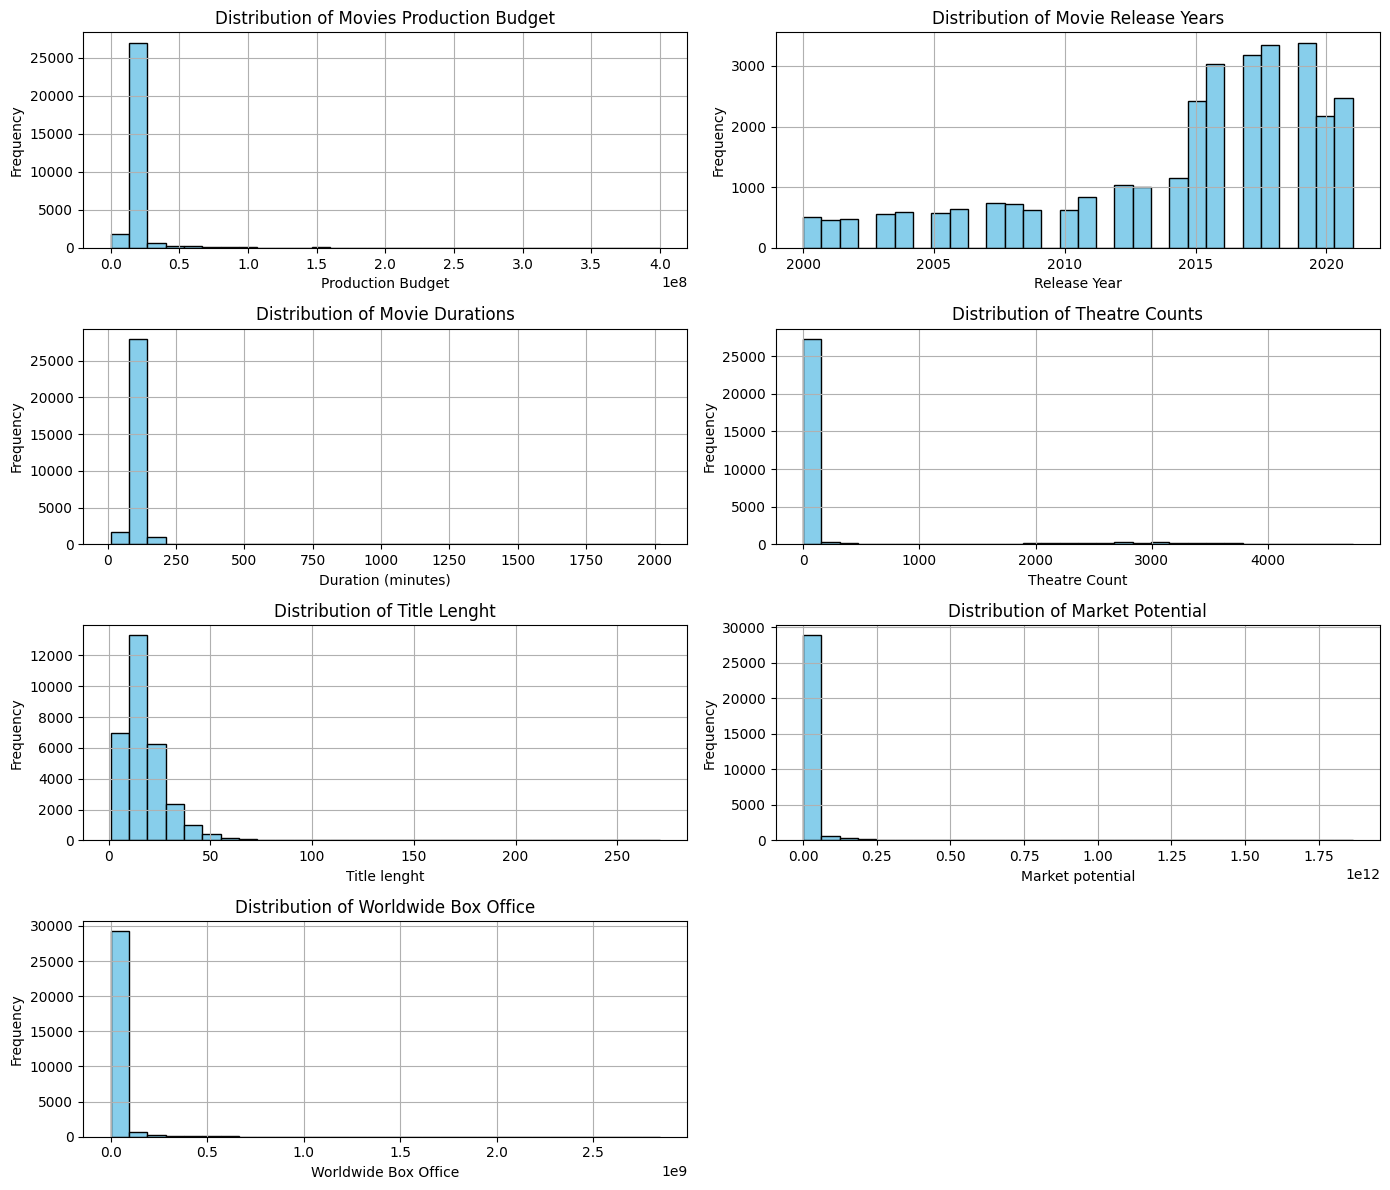

In [45]:

# Plot the overall distribution of movies' production budget
plt.figure(figsize=(14, 12))
plt.subplot(4, 2, 1)
plt.hist(df['production_budget'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movies Production Budget')
plt.xlabel('Production Budget')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of movie release years
plt.subplot(4, 2, 2)
plt.hist(df['year'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Release Years')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of movie durations
plt.subplot(4, 2, 3)
plt.hist(df['duration'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of theatre counts
plt.subplot(4, 2, 4)
plt.hist(df['theatre_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Theatre Counts')
plt.xlabel('Theatre Count')
plt.ylabel('Frequency')
plt.grid(True)

#plot the overall distribution of title lenght
plt.subplot(4, 2, 5)
plt.hist(df['title_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Title Lenght')
plt.xlabel('Title lenght')
plt.ylabel('Frequency')
plt.grid(True)

#plot the overall distribution of market potential 
plt.subplot(4, 2, 6)
plt.hist(df['market_potential'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Market Potential')
plt.xlabel('Market potential')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of worldwide box office
plt.subplot(4, 2, 7)
plt.hist(df['worldwide_box_office'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Worldwide Box Office')
plt.xlabel('Worldwide Box Office')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


The distribution of the variables presents lots of outliers, which are plotted in the cell below.

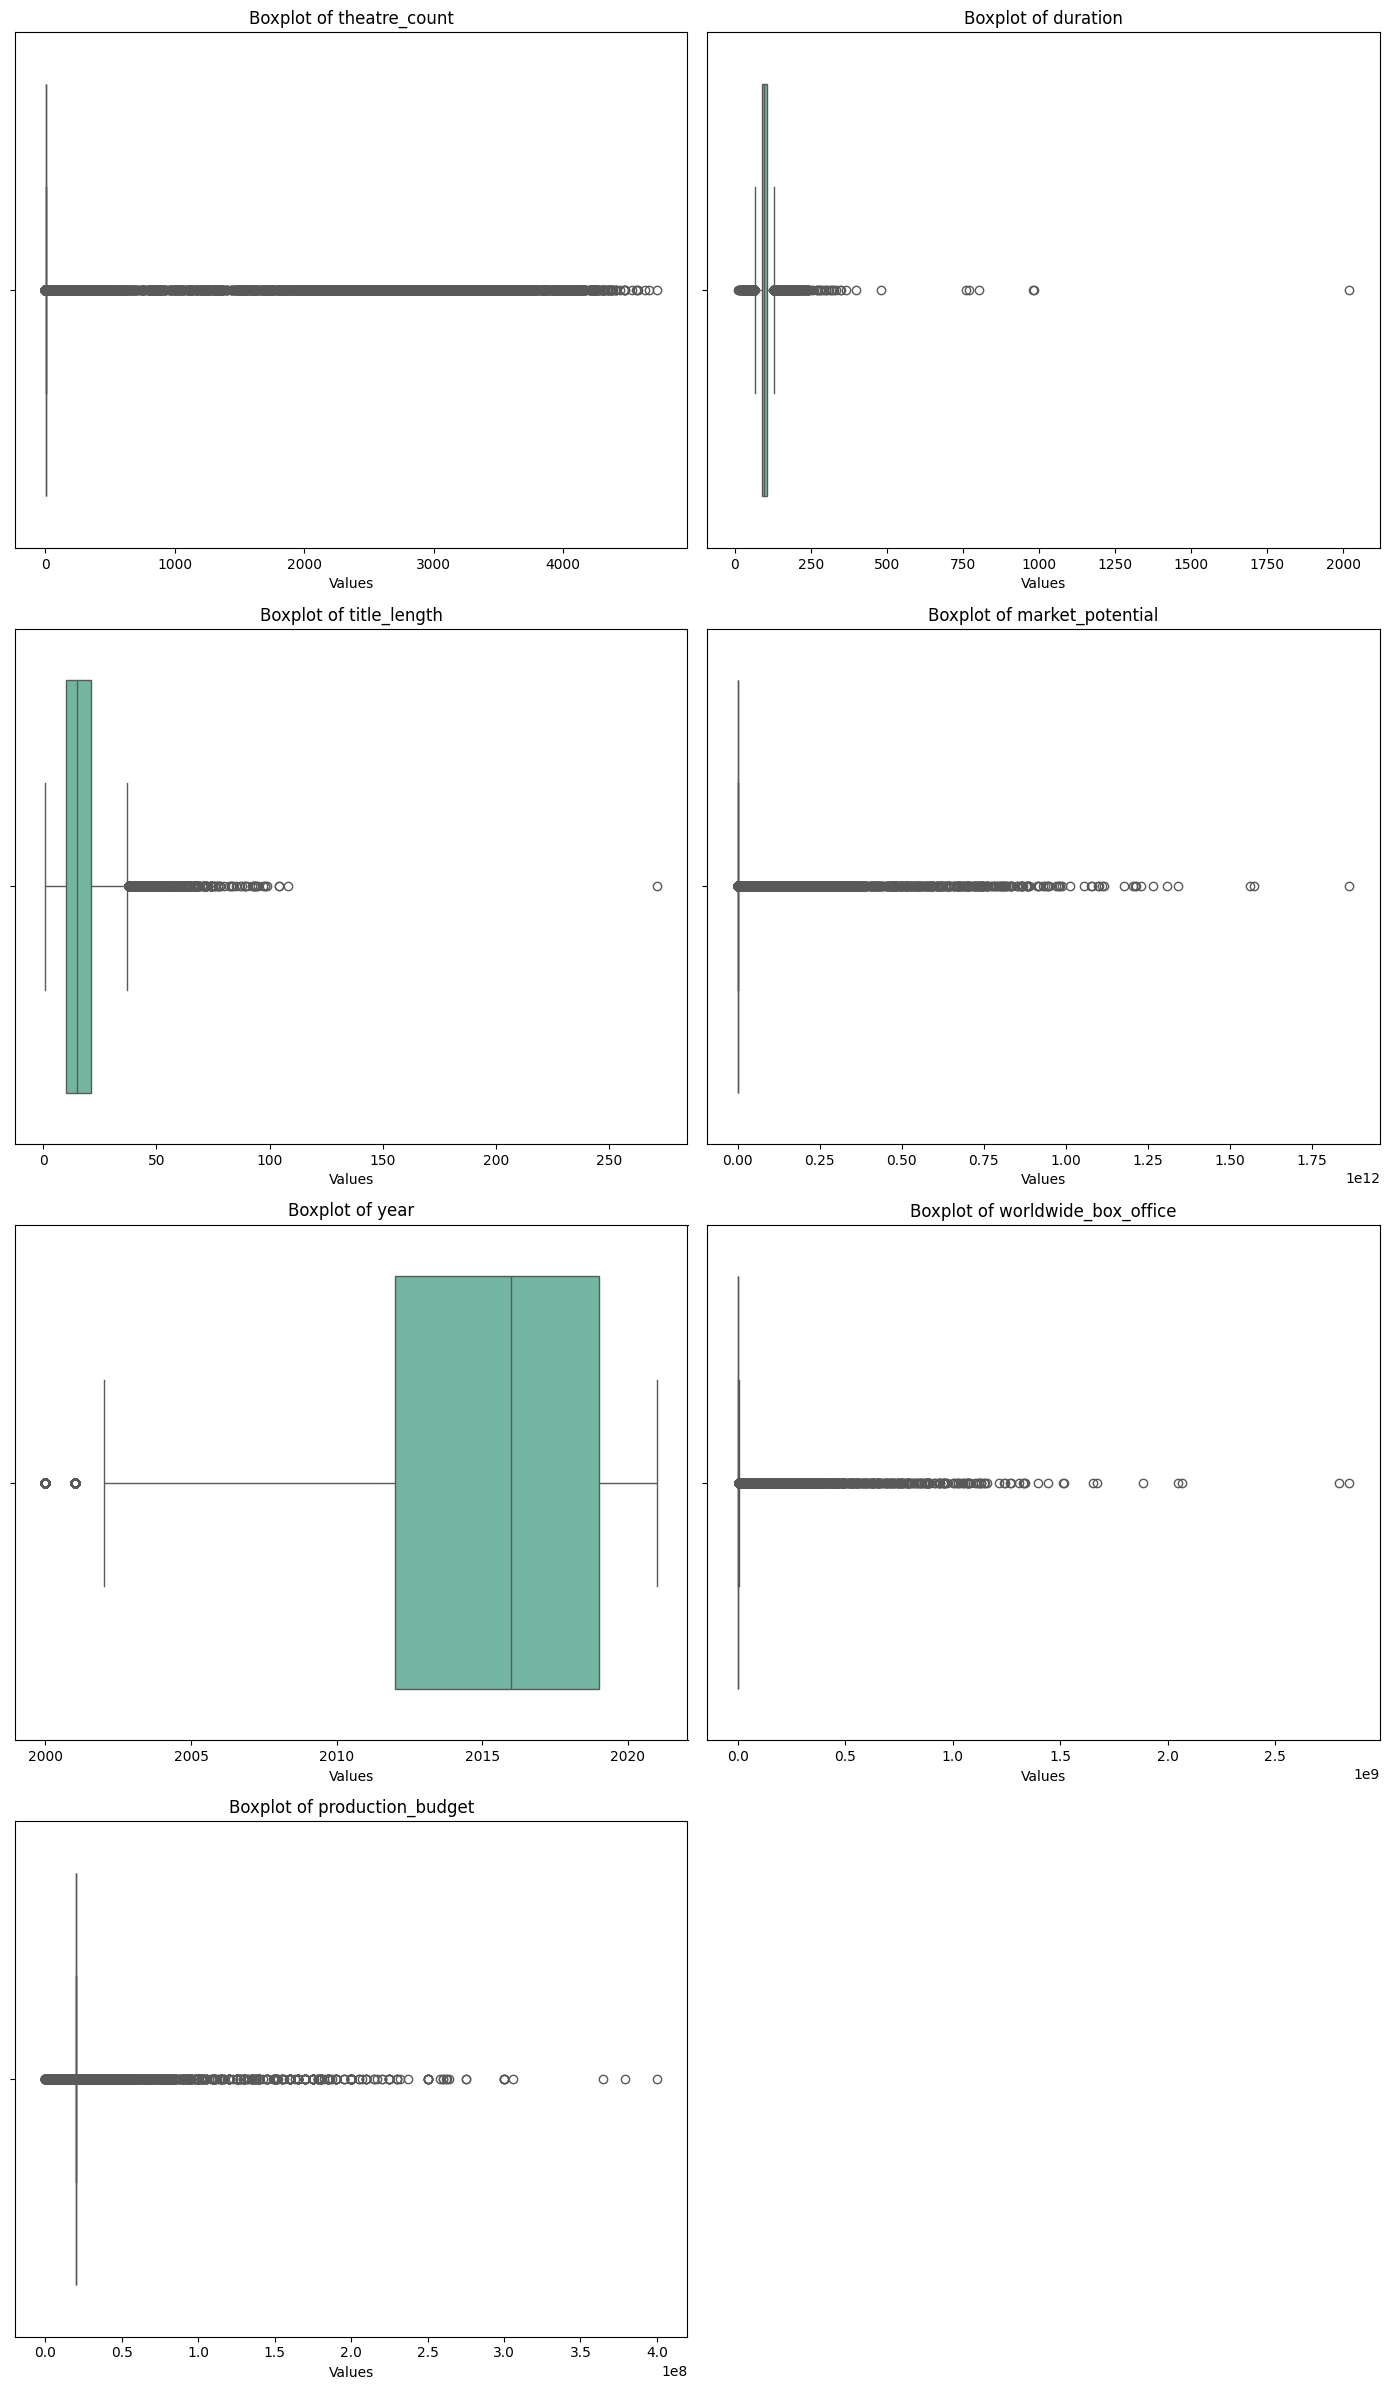

In [46]:
# Providing visual information of the distribution and outliers for all integer and float variables 
# Selecting columns to plot
columns_to_plot = ['theatre_count', 'duration', 'title_length', 'market_potential', 'year', 
                   'worldwide_box_office', 'production_budget']

# Determine the number of rows needed
num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6*num_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create boxplots for each column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x=df[column], orient="h", palette="Set2", ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel('Values')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


Concening the variable year, the presence of only a few dots outside the box indicates that there are relatively few data points that fall outside the typical range of values (as defined by the IQR) . Thus there are few outliers. Something similar can be observed for the variable title lenght, whose plot also indicates frewer outliers than for the other variables for which many outliers are present. The cell below aims at removing outliers from the dataset.

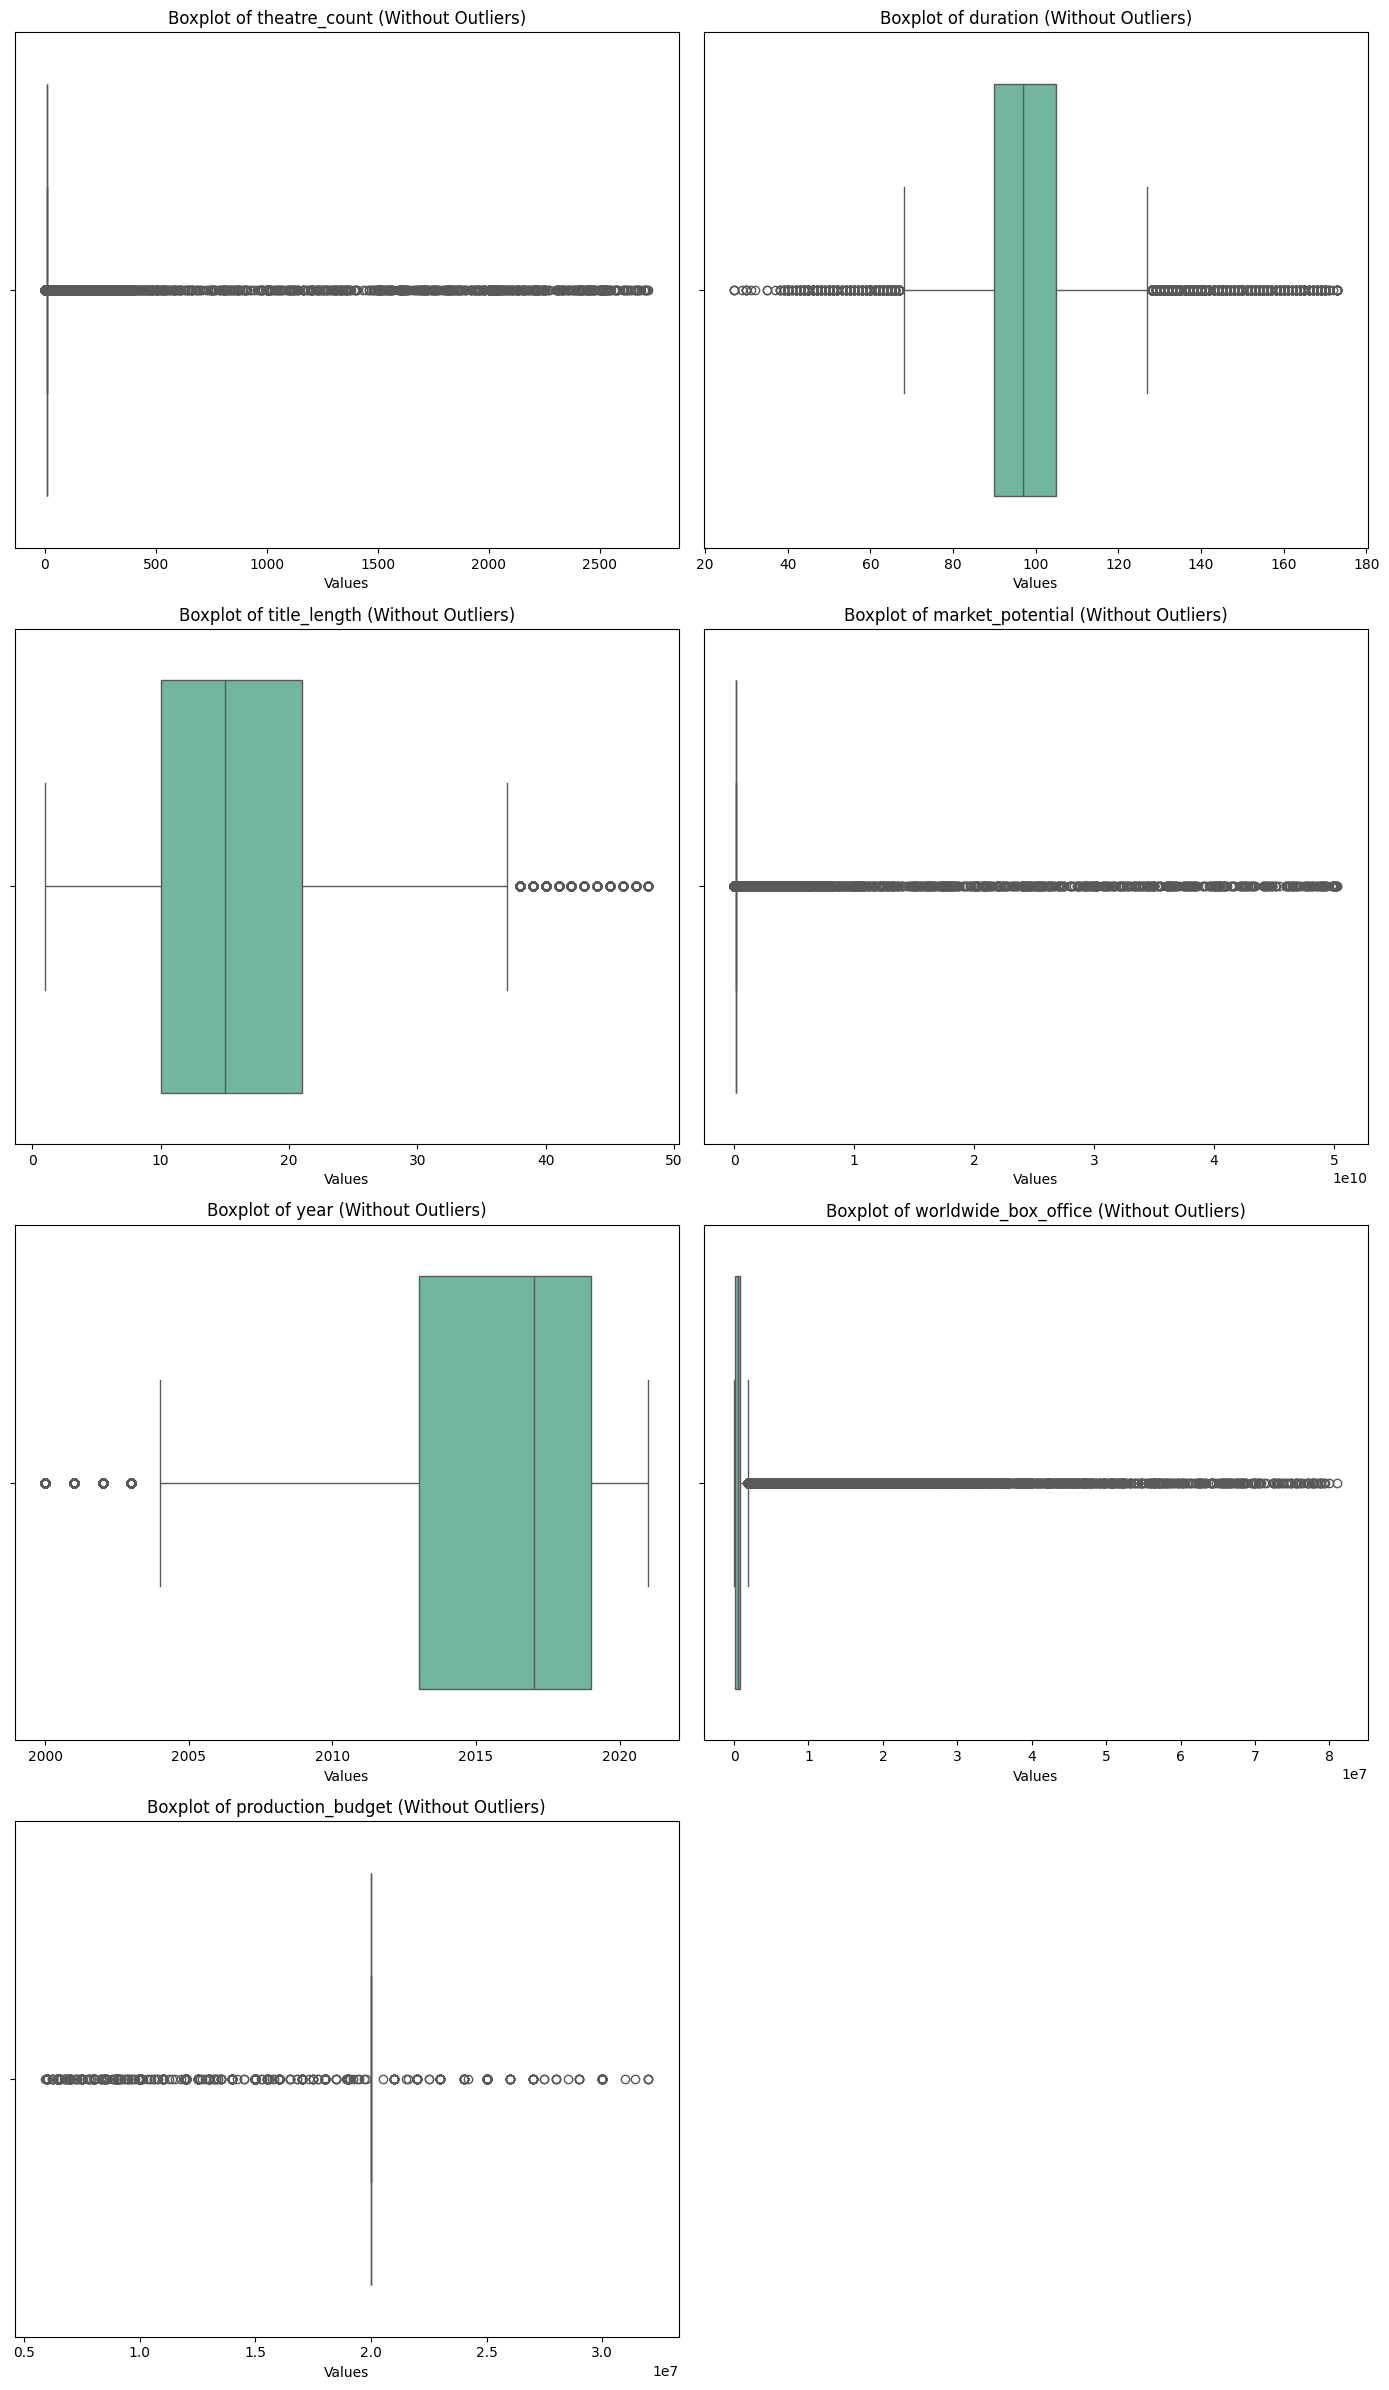

In [47]:
# Define a function to remove outliers from a column
def remove_outliers(column):
    # Calculate mean and standard deviation
    mean = df[column].mean()
    std_dev = df[column].std()
    
    # Define the threshold for outliers (e.g., 3 standard deviations from the mean)
    threshold = 3 * std_dev
    
    # Remove outliers beyond the threshold
    df_filtered = df[(df[column] >= mean - threshold) & (df[column] <= mean + threshold)]
    
    return df_filtered

# Remove outliers from each column
for column in columns_to_plot:
    df = remove_outliers(column)

# Plot the boxplots of the columns without outliers
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6*num_rows))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x=df[column], orient="h", palette="Set2", ax=axes[i])
    axes[i].set_title(f'Boxplot of {column} (Without Outliers)')
    axes[i].set_xlabel('Values')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


The removal of outliers was partially sucessfull. Some outliers were removed, yet not all. For this reason log transformation was applied to the data as an alternative approach.


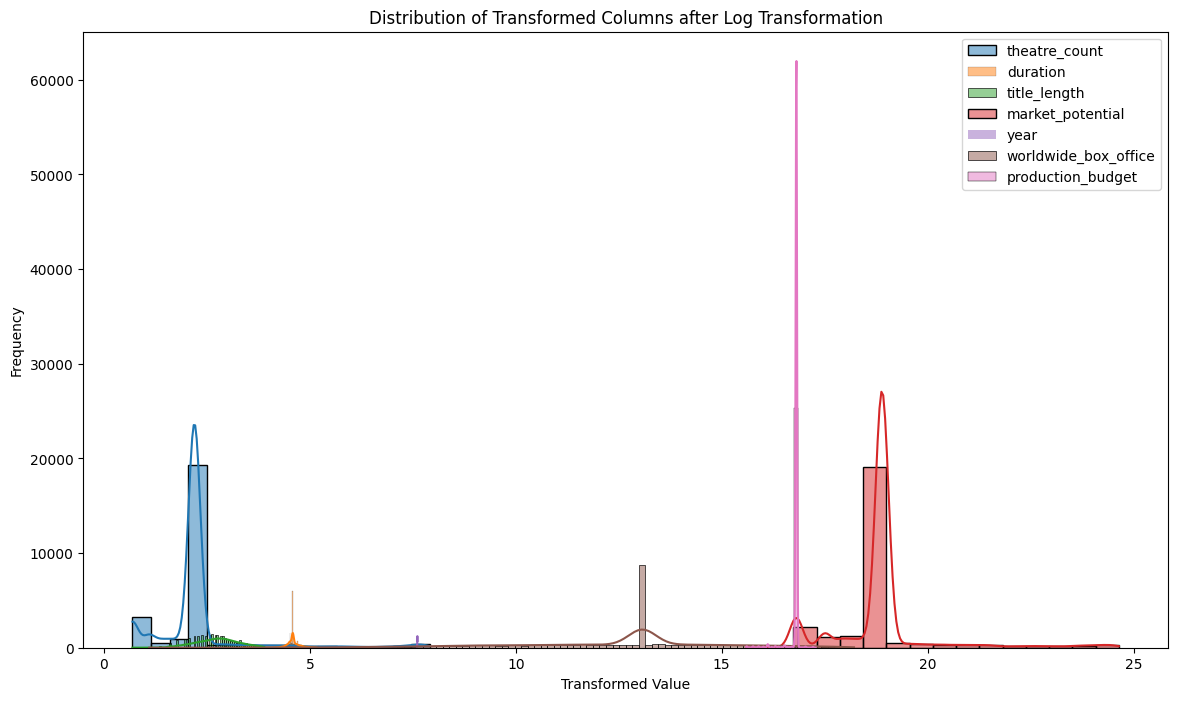

In [48]:
# Define the columns with outliers
columns_with_outliers = ['theatre_count', 'duration', 'title_length', 'market_potential', 'year', 
                         'worldwide_box_office', 'production_budget']

# Function to apply log transformation to columns with outliers
def apply_log_transformation(df, columns):
    for col in columns:
        # Add 1 to handle zero values
        df[col] = np.log1p(df[col])
    return df

# Apply log transformation to columns with outliers
df = apply_log_transformation(df, columns_with_outliers)

# Plot the distribution of transformed columns to visualize the effect
plt.figure(figsize=(14, 8))
for col in columns_with_outliers:
    sns.histplot(df[col], kde=True, label=col, alpha=0.5)
plt.title('Distribution of Transformed Columns after Log Transformation')
plt.xlabel('Transformed Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


After appplying the log transformation to specific columns their distribution results more symmetrical and approaches more a normal distribution. This can also be seen in the plots below.

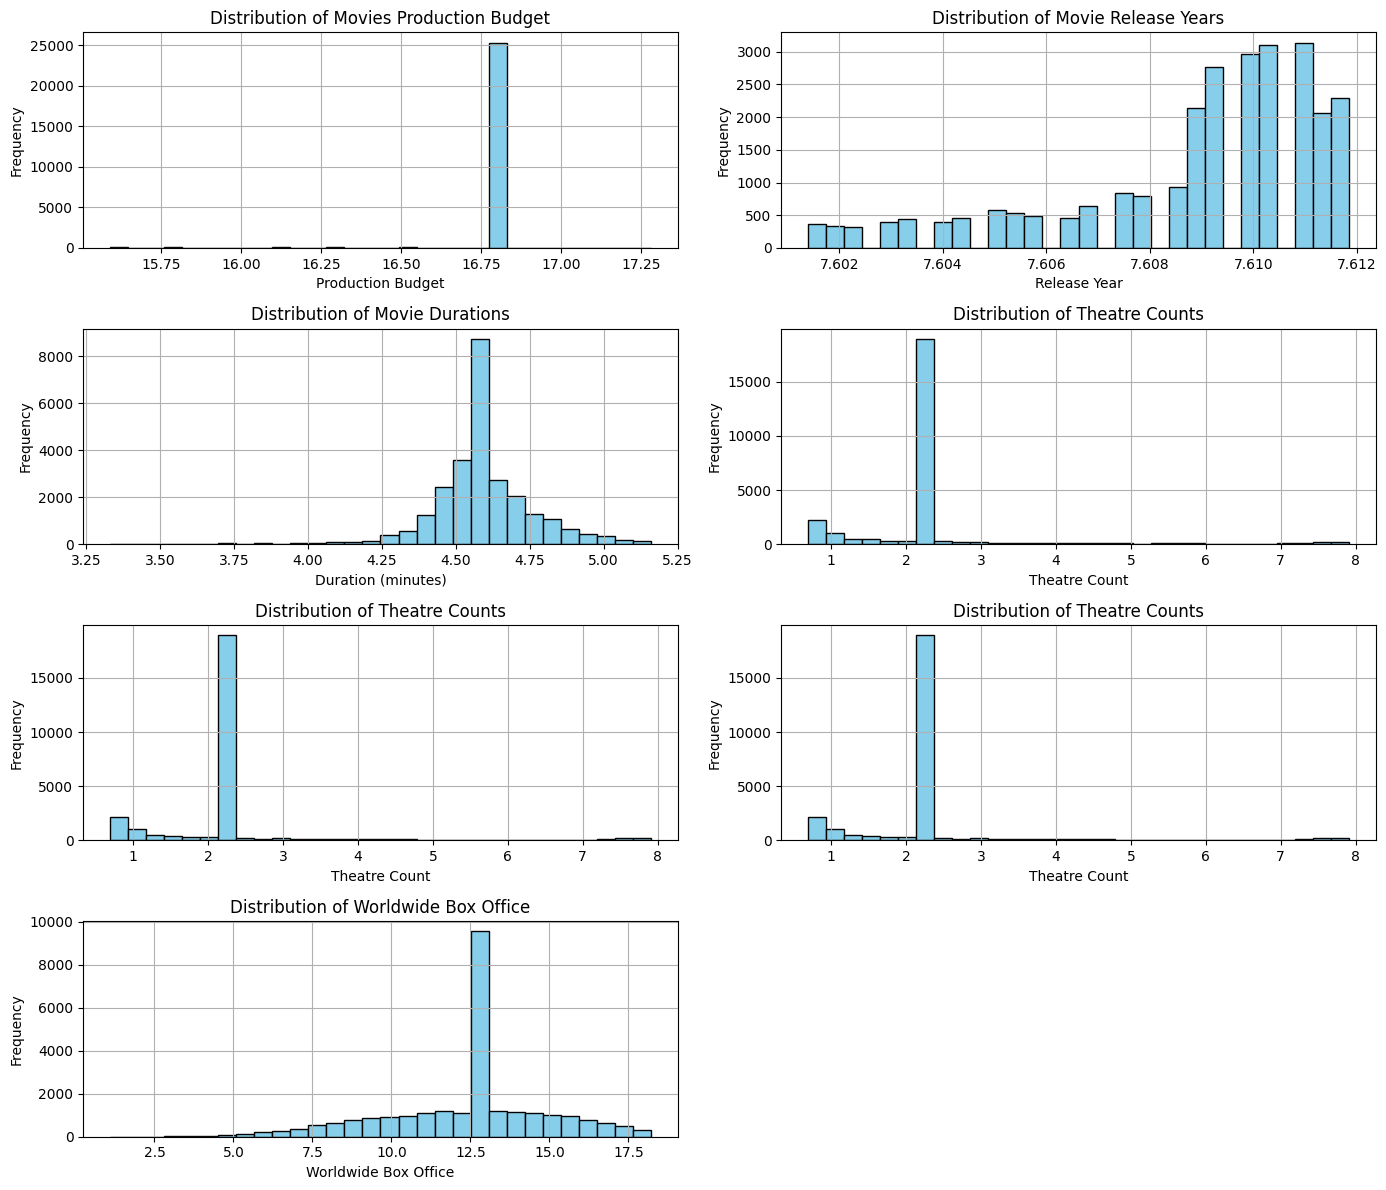

In [49]:

# Plot the overall distribution of movies' production budget
plt.figure(figsize=(14, 12))
plt.subplot(4, 2, 1)
plt.hist(df['production_budget'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movies Production Budget')
plt.xlabel('Production Budget')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of movie release years
plt.subplot(4, 2, 2)
plt.hist(df['year'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Release Years')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of movie durations
plt.subplot(4, 2, 3)
plt.hist(df['duration'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of theatre counts
plt.subplot(4, 2, 4)
plt.hist(df['theatre_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Theatre Counts')
plt.xlabel('Theatre Count')
plt.ylabel('Frequency')
plt.grid(True)

#plot the overall distribution of title lenght
plt.subplot(4, 2, 5)
plt.hist(df['theatre_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Theatre Counts')
plt.xlabel('Theatre Count')
plt.ylabel('Frequency')
plt.grid(True)

#plot the overall distribution of market potential 
plt.subplot(4, 2, 6)
plt.hist(df['theatre_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Theatre Counts')
plt.xlabel('Theatre Count')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the overall distribution of worldwide box office
plt.subplot(4, 2, 7)
plt.hist(df['worldwide_box_office'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Worldwide Box Office')
plt.xlabel('Worldwide Box Office')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


The above presented variables have a more normal distribution after log transformation.

In [50]:
# Get the list of numerical columns
numerical_columns = df.select_dtypes(include='number').columns

# Impute missing values with the median for all numerical columns
for column in numerical_columns:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Checking if there are any remaining missing values
missing_values_after_imputation = df[numerical_columns].isnull().sum()
print("Missing values in numerical variables after imputation:")
print(missing_values_after_imputation)

df.head(20)

Missing values in numerical variables after imputation:
year                    0
worldwide_box_office    0
production_budget       0
theatre_count           0
duration                0
title_length            0
market_potential        0
dtype: int64


,year,title,genre,worldwide_box_office,production_budget,theatre_count,duration,title_length,market_potential
0,7.601402,Bakha Satang,Drama,11.246052,16.811243,2.197225,4.867534,2.564949,18.890684
2,7.601402,Santitos,Unknown,13.071750,16.811243,2.197225,4.663439,2.197225,18.890684
3,7.602401,Frank McKlusky C.I.,Unknown,13.071750,16.811243,2.197225,4.584967,2.995732,18.890684
4,7.602401,A Walk to Remember,Drama,17.645474,16.213406,7.788212,4.584967,2.944439,24.001203
5,7.602401,Zig Zag,Unknown,13.071750,16.811243,0.693147,4.584967,2.079442,16.811243
6,7.602401,TakhtÃƒÂ© siah,Drama,13.071750,16.811243,1.791759,4.584967,2.708050,18.420681
7,7.605890,"Angry Monk: Reflections on Tibet, The",Documentary,13.071750,16.811243,0.693147,4.584967,3.637586,16.811243
8,7.602401,30 Years to Life,Comedy,13.071750,16.811243,0.693147,4.584967,2.833213,16.811243
9,7.605392,The Killing of John Lennon,Drama,13.071750,16.811243,0.693147,4.584967,3.295837,16.811243
11,7.605392,Little Chenier,Drama,13.071750,16.811243,2.890372,4.584967,2.708050,19.644456


To have a more comprehensive overview of the variables in the dataset and their interelationships, a correlation analysis was performed between all numerical variables. The resulting correaltion coefficients and significance values are plotted in the heatmap below. The variable "year" was not included in this analysis as considered as an ordinal (and thus partly nominal) variable.

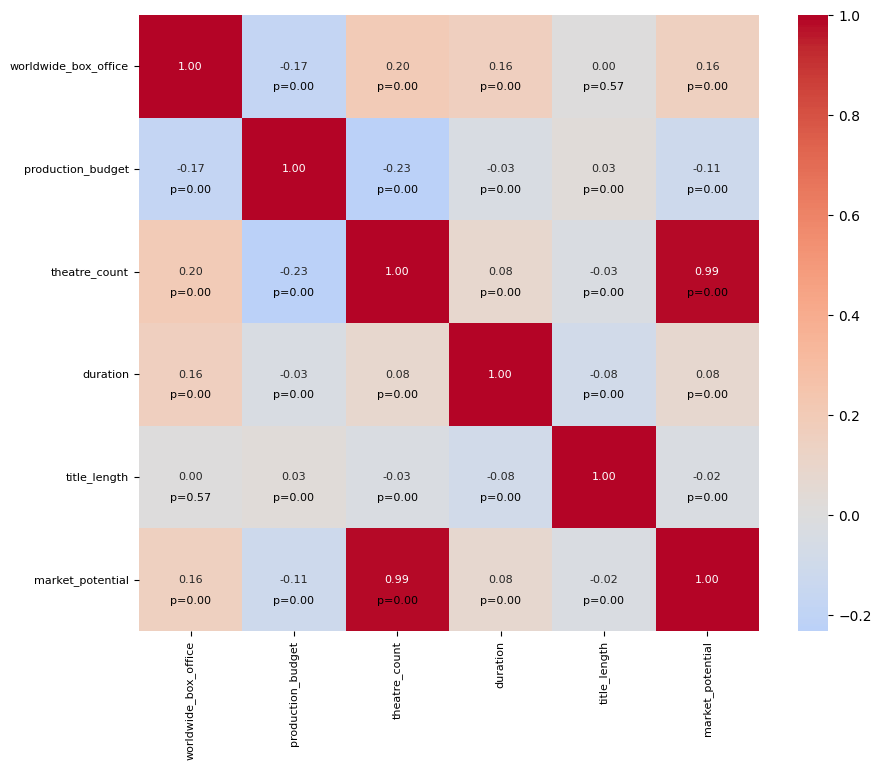

In [51]:

# correlation analysis between all numerical variables except 'year'

# Create a temporary new DataFrame with only numerical columns (excluding 'year')
numerical_columns = df.select_dtypes(include='number').columns
numerical_columns = numerical_columns.drop('year')  # Exclude 'year' column
temp_df = df[numerical_columns].copy()

# Calculate correlation matrix and p-values
corr_matrix = temp_df.corr()
p_values = np.zeros_like(corr_matrix.values)
for i in range(len(temp_df.columns)):
    for j in range(len(temp_df.columns)):
        corr, p_value = pearsonr(temp_df.iloc[:, i], temp_df.iloc[:, j])
        p_values[i, j] = p_value

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjusting figure size 
heatmap = sns.heatmap(corr_matrix, annot=True, center=0, annot_kws={"size": 8}, cmap='coolwarm', fmt=".2f")

# Adding p-values to the heatmap below the correlation coefficients
for i in range(len(temp_df.columns)):
    for j in range(len(temp_df.columns)):
        if i != j:
            heatmap.text(j+0.5, i+0.7, 'p={:.2f}'.format(p_values[i, j]), 
                         horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')

# Creating labels for columns and rows 
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)

plt.show()


No significant strong or moderate correlations have been found between the numerical variables in the dataset. Only significant weak correlations can be observed between :
- worldwide box office and production budget  (negative)
- worlwide box office and theatre count (positive)
- worldwide box office and duration (positve) 
- worldwide box office and marketpotential (positive) (not surpring as market potential is built on theatre count and production budget)

To investigate the effect of the ordinal variable year, movies age classes were created and a one way anova was performed to test the effect of age classes of worldwide box office.

In [52]:
# Define the bins for age categories 
bins = [7.6, 7.605, 7.61, 7.615]  # defining bins based on new values of year after log transformation
# Define the labels for the age categories
labels = ['Category 1', 'Category 2', 'Category 3']
# Create a new column 'age_category' based on the year values
df['age_category'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
# Print the counts of movies in each age category
print(df['age_category'].value_counts())

from scipy.stats import f_oneway

# Extract the worldwide box office values for each age category
category1 = df[df['age_category'] == 'Category 1']['worldwide_box_office']
category2 = df[df['age_category'] == 'Category 2']['worldwide_box_office']
category3 = df[df['age_category'] == 'Category 3']['worldwide_box_office']

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(category1, category2, category3)

# Print the results
print("One-way ANOVA results:")
print("F-statistic:", f_statistic)
print("P-value:", p_value)



age_category
Category 2    12556
Category 3    10596
Category 1     3290
Name: count, dtype: int64
One-way ANOVA results:
F-statistic: 754.5550174098537
P-value: 2.051e-319


In [53]:
# Drop the column 'age_category'
df.drop(columns=['age_category'], inplace=True)

The one way anova was significant (as it can be seen by the p value which is extremely close to 0), indicating an effect of age category on worldwide box office. However, the assumption of normal distribution of the dependent variable is not well met, for this reason it is hard to understand to what extent this conclusion applies. 
Next the categorical variable "genre" was investigated. Below the plot on the left displays the distribution of the different genres in the dataset, while the one on the right shows the worldwide box office of movies with different genres.

genre
Drama                  8359
Documentary            4384
Comedy                 3965
Thriller/Suspense      1894
Unknown                1614
Adventure              1368
Horror                 1348
Action                 1302
Romantic Comedy        1003
Concert/Performance     570
Musical                 217
Black Comedy            189
Multiple Genres         146
Western                  74
Educational               5
Reality                   4
Name: count, dtype: int64


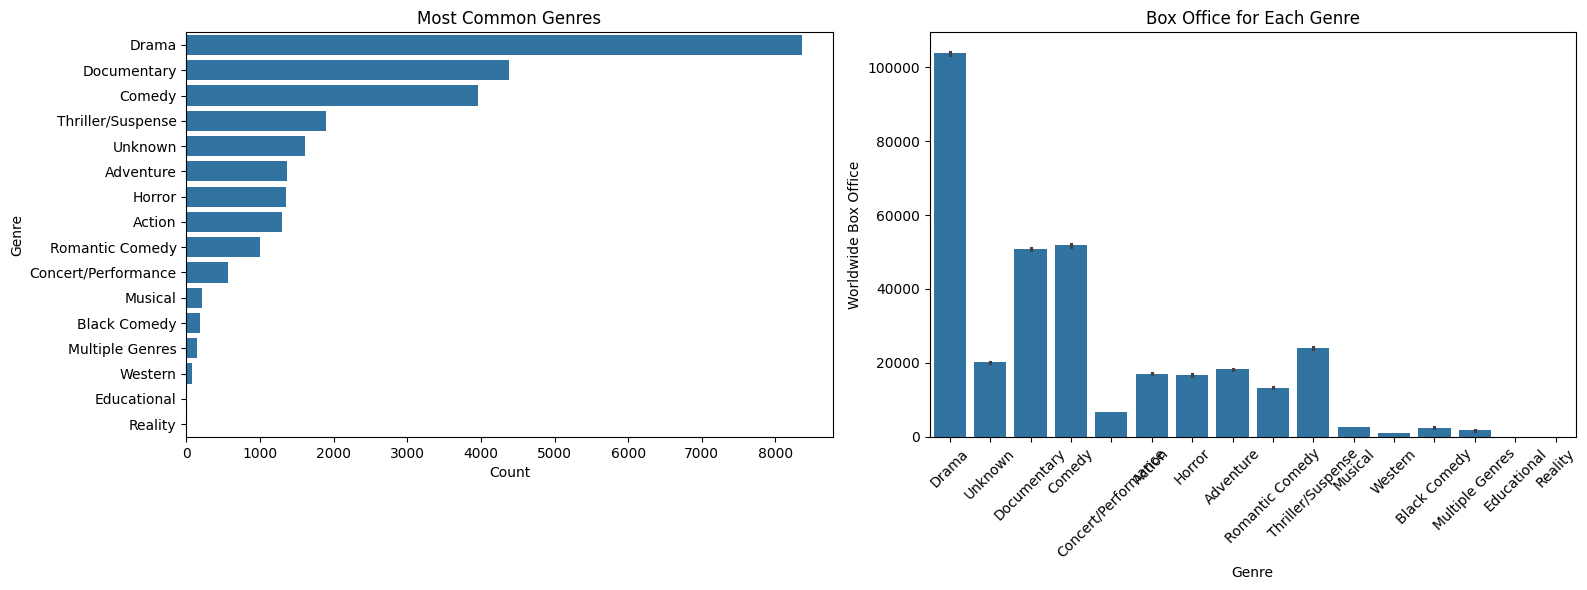

In [54]:
# GENRE
# Plotting most common genres in the dataset
# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the most common genres
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index, ax=axes[0])
axes[0].set_title('Most Common Genres')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre')

# Get the count of movies for each genre
genre_counts = df['genre'].value_counts()
print(genre_counts)

# Plotting box office for each genre
sns.barplot(x='genre', y='worldwide_box_office', data=df, estimator=sum, ax=axes[1])
axes[1].set_title('Box Office for Each Genre')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Worldwide Box Office')
axes[1].tick_params(axis='x', rotation=45)  # Rotate genre labels for better readability

# Adjust layout
plt.tight_layout()
plt.show()


The most common genre in the dataset is "drama" with 8359 movies, followed by documentary (4384 movies) and comedy (3965 movies).The are few movies assigned to the genre "educational" (5 movies) or "reality" (4 movies). In addition, 1704 movies in the dataset were not assigned to a specific genre and thus their genre was labelled as unknown.
The genre "drama" is also the genre with the highest worlwide box office followed by "unknow" , "documentary" and "comedy".

As for year, another one way anova was performed to test the effect of genre on world wide box office. This was done to check whether the differences plotted in the graph on the top right  were significant or not.

In [56]:
from scipy import stats

# Assume 'genre' is a categorical variable and 'box_office' is the numerical variable

# List to store box office values for each genre
genre_groups = []

# Get unique genres
unique_genres = df['genre'].unique()

# Collect box office values for each genre
for genre in unique_genres:
    genre_groups.append(df[df['genre'] == genre]['worldwide_box_office'])

# Perform one-way ANOVA
anova_result = stats.f_oneway(*genre_groups)

# Print the ANOVA result
print("ANOVA F-value:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)


ANOVA F-value: 80.49771533187436
ANOVA p-value: 1.9890842100795395e-242


The p-value is very close to zero, indicating an extremely strong statistical significance. This means that genre has an effect on worldwide box office.  However, the assumption of normal distribution of the dependent variable is not well met, for this reason it is hard to understand to what extent this conclusion applies. 

In [59]:
# Save the DataFrame to a CSV file in the same folder as the script or notebook
cleaned_data = 'cleaned_data.csv'
df.to_csv(cleaned_data, index=False)

print(f'CSV file saved at: {cleaned_data}')

CSV file saved at: cleaned_data.csv


The cleaned dataset was saved to a csv file which will be the basis for further modelling analyses.